In [1]:
import os
import time
from preprocessor import Preprocessor
from weld_segmentator_v2 import WeldSegmentator_FgSegNet_v2
from intermediate_processor import IntermediateProcessor
from defect_detector_M import DefectDetector
from postprocessor import Postprocessor
import matplotlib.pyplot as plt
import cv2

path_input_img = './raw_scans/'
path_processing_img = './processing_scans/'
path_weld_mask = './weld_masks/'
path_scale_weld = './scale_weld_area/'
path_defect_mask = './defect_masks/'
path_results = './results/'

def recognizer(tiff_name):
    """ Запускает процесс распознавания дефектов на снимке. """   
    print("Предобработка исходного снимка...")
    preprocessor = Preprocessor(tiff_name)
    preprocessor.process_by_gradient(path_input_img)
    preprocessor.normalize_img()
    process_img_name = preprocessor.convert_to_8bit(path_processing_img)
    
    print("Сегментация области шва...")
    weld_segmentator = WeldSegmentator_FgSegNet_v2()
    weld_segmentator.get_images(path_processing_img, process_img_name)
    weld_segmentator.predict_weld_mask()
    weld_segmentator.apply_threshold()
    mask_name = weld_segmentator.save_weld_masks(path_weld_mask, process_img_name)
    
    print("Формирование области шва...")
    medium_processor = IntermediateProcessor()
    weld_flag = medium_processor.find_weld_boundaries(path_weld_mask, mask_name)
    if weld_flag == -1:
        return -1
    medium_processor.add_allowances()
    medium_processor.get_weld_and_gray_bgr(path_processing_img, process_img_name)
    initial_boundar1, initial_boundar2 = medium_processor.form_weld_area(path_scale_weld, process_img_name)
    
    print("Распознавание дефектов...")
    defect_detector = DefectDetector()
    defect_detector.get_weld_area(path_scale_weld, process_img_name)
    defect_detector.predict_defect_mask()
    defect_detector.apply_threshold()
    defect_detector.save_defect_mask(path_defect_mask, process_img_name)
    
    print("Постобработка снимка...")
    postprocessor = Postprocessor()
    postprocessor.scale_mask(initial_boundar1, initial_boundar2, path_defect_mask, process_img_name)
    result = postprocessor.overlay_mask_on_image(path_processing_img, process_img_name, path_results)
    return result

Using TensorFlow backend.


Предобработка исходного снимка...
Сегментация области шва...
1/1 [==============================] - 1s 635ms/step
Формирование области шва...
Распознавание дефектов...
1/1 [==============================] - 0s 309ms/step
Постобработка снимка...


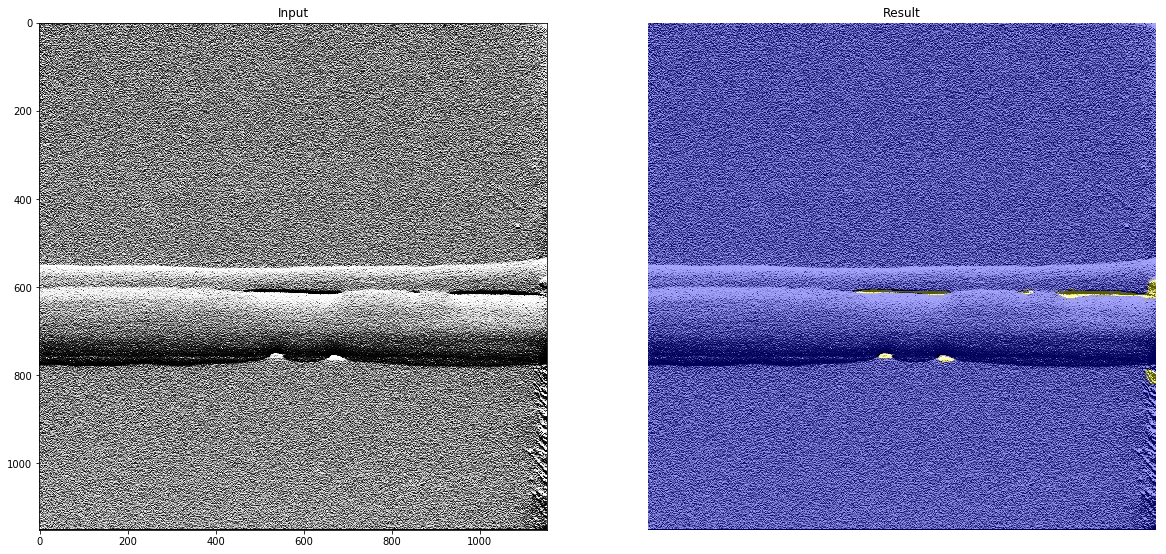

In [3]:
# Распознавание дефектов на снимке
img_number = 9
tiff_names = os.listdir(path_input_img)
result = recognizer(tiff_names[img_number])

# Вывод результатов распознавания
num_in_row = 1
num_in_col = 2
plt.rcParams['figure.figsize'] = (20.0, 14.0)

x = cv2.imread(path_processing_img + tiff_names[img_number][:-4]+'jpg')
plt.subplot(num_in_row, num_in_col, 1)
plt.imshow(x)
plt.title('Input')

y = result
plt.subplot(num_in_row, num_in_col, 2)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('Result')

plt.axis('off')   
plt.show()